# Import Modules

In [0]:
import os
import time
import datetime
import string
import random
import math
import json
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
tf.reset_default_graph()
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

**List the devices available to tensorflow**

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 960021100176991788, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11288962663
 locality {
   bus_id: 1
 }
 incarnation: 17502361377285727171
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

**Make the result reproducible by setting the seed of numpy and tensorflow**

In [3]:
# np_rand_seed = random.randint(0,100)
# tf_rand_seed = random.randint(0,100)
np_rand_seed = 26
tf_rand_seed = 21
np.random.seed(np_rand_seed)
tf.set_random_seed(tf_rand_seed)
print("numpy random seed: ",np_rand_seed)
print("tensorflow random seed: ", tf_rand_seed)

numpy random seed:  26
tensorflow random seed:  21


# Load the image and mask data

## Authenticate and load zipped data to kernel

**Authentication via google auth**

In [0]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

**Upload a file from google cloud where file ids are stored as a json**

In [5]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

file_id_data= json.loads(uploaded['file_id.json'])

Saving file_id.json to file_id (4).json
User uploaded file "file_id.json" with length 222 bytes


**Download files to the kernel**

In [0]:
downloaded1 = drive.CreateFile({'id':file_id_data["stage1_train"]}) 
downloaded1.GetContentFile('stage1_train.zip')  
downloaded2 = drive.CreateFile({'id':file_id_data["stage1_test"]}) 
downloaded2.GetContentFile('stage1_test.zip')
downloaded3 = drive.CreateFile({'id':file_id_data["stage1_train_labels"]}) 
downloaded3.GetContentFile('stage1_train_labels.csv')

**Load the train labels**

In [0]:
train_labels = pd.read_csv("stage1_train_labels.csv")

In [8]:
train_labels.head(10)

,ImageId,EncodedPixels
0,00071198d059ba7f5914a526d124d28e6d010c92466da2...,6908 1 7161 8 7417 8 7672 9 7928 9 8184 9 8440...
1,00071198d059ba7f5914a526d124d28e6d010c92466da2...,36269 7 36523 11 36778 13 37033 15 37288 17 37...
2,00071198d059ba7f5914a526d124d28e6d010c92466da2...,19919 6 20174 8 20429 10 20685 11 20941 12 211...
3,00071198d059ba7f5914a526d124d28e6d010c92466da2...,18671 6 18926 8 19181 9 19436 10 19691 11 1994...
4,00071198d059ba7f5914a526d124d28e6d010c92466da2...,40158 3 40413 5 40669 5 40925 5 41182 3
5,00071198d059ba7f5914a526d124d28e6d010c92466da2...,58535 6 58791 10 59047 12 59303 16 59553 2 595...
6,00071198d059ba7f5914a526d124d28e6d010c92466da2...,31989 7 32244 12 32499 14 32754 15 33009 16 33...
7,00071198d059ba7f5914a526d124d28e6d010c92466da2...,11966 4 12220 9 12473 14 12729 15 12984 16 132...
8,00071198d059ba7f5914a526d124d28e6d010c92466da2...,58148 3 58403 5 58657 10 58912 13 59167 15 594...
9,00071198d059ba7f5914a526d124d28e6d010c92466da2...,14825 3 15080 5 15336 5 15592 5 15849 3


## Making directories and unzipping train and test data to repective directories

**Make directories for train and test images**

In [9]:
!if [ ! -d "/stage1_train" ]; then echo "directory already exists"; else mkdir stage1_train; fi

directory already exists


In [10]:
!if [ ! -d "/stage1_test" ]; then echo "directory already exists"; else mkdir stage1_test; fi


directory already exists


**Load the train and test data into designated directories**

In [11]:
!if [ "$(ls -A stage1_train)" ]; then echo "Files are already there"; else unzip stage1_train.zip -d stage1_train; fi

Files are already there


In [12]:
!if [ "$(ls -A stage1_test)" ]; then echo "Files are already there"; else unzip stage1_test.zip -d stage1_test; fi

Files are already there


# Visualize sample medical images and masks

**Image dimensions for input placeholder**

In [0]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

**Load train and test ids**

In [0]:
TRAIN_PATH = './stage1_train/'
TEST_PATH = './stage1_test/'

In [0]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
train_ids = np.array(train_ids)
test_ids = next(os.walk(TEST_PATH))[1]
test_ids = np.array(test_ids)

**Size of train and test sets**

In [16]:
print("size of train set:",len(train_ids))

size of train set: 670


In [17]:
print("size of test set:",len(test_ids))

size of test set: 65


**A function for generating batch of images, masks and their corresponding shapes**

In [0]:
def generate_batch(indices, test_set = False):
  
    
    # extract the id based of train/test set
    if test_set is False:
        batch_ids = train_ids[indices]
    else:
        batch_ids = test_ids[indices]
        
    # initialize numpy array to hold image and mask 
    X = np.zeros((len(batch_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
    Y = np.zeros((len(batch_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
    # shapes of the images
    shapes = np.zeros((len(batch_ids), 2))
  
    # iterate through each image
    for n, id_ in enumerate(batch_ids):
      
        # construct path for the image
        if test_set is False:
            path = TRAIN_PATH + id_
        else:
            path = TEST_PATH + id_
          
        # load image and shape
        img = imread(path + '/images/' + id_ + '.png')/255.0
        shape = img.shape[:2]
        shapes[n] = shape
        
        # extract the first 3 channels only
        img = img[:,:,:IMG_CHANNELS]
        # resize the image so that all images are of same shape
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X[n] = img

        # if it is a trains set then extract the masks as well
        if test_set is False:
          
            # initilize numpy array for the mask
            mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
            
            # iterate through each mask and carry our a pixel wise max operation
            for mask_file in next(os.walk(path + '/masks/'))[2]:
                mask_ = imread(path + '/masks/' + mask_file)/255.0
#                 mask_ = imread(path + '/masks/' + mask_file)
                mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
                mask = np.maximum(mask, mask_)
            Y[n] = mask
    
    
    if test_set is False:
        return X, Y, shapes
    else:
        return X, shapes

**Generate a batch**

In [0]:
indices = np.array([1,2,4,5,6,7,8,9,10])
X, Y, shapes = generate_batch(indices)

**Squeeze the mask data**

In [0]:
Y_squeezed = np.squeeze(Y)

In [21]:
print(X.shape)
print(Y.shape)
print(Y_squeezed.shape)
print(shapes.shape)

(9, 128, 128, 3)
(9, 128, 128, 1)
(9, 128, 128)
(9, 2)


**Display the sample image and corresponding mask**

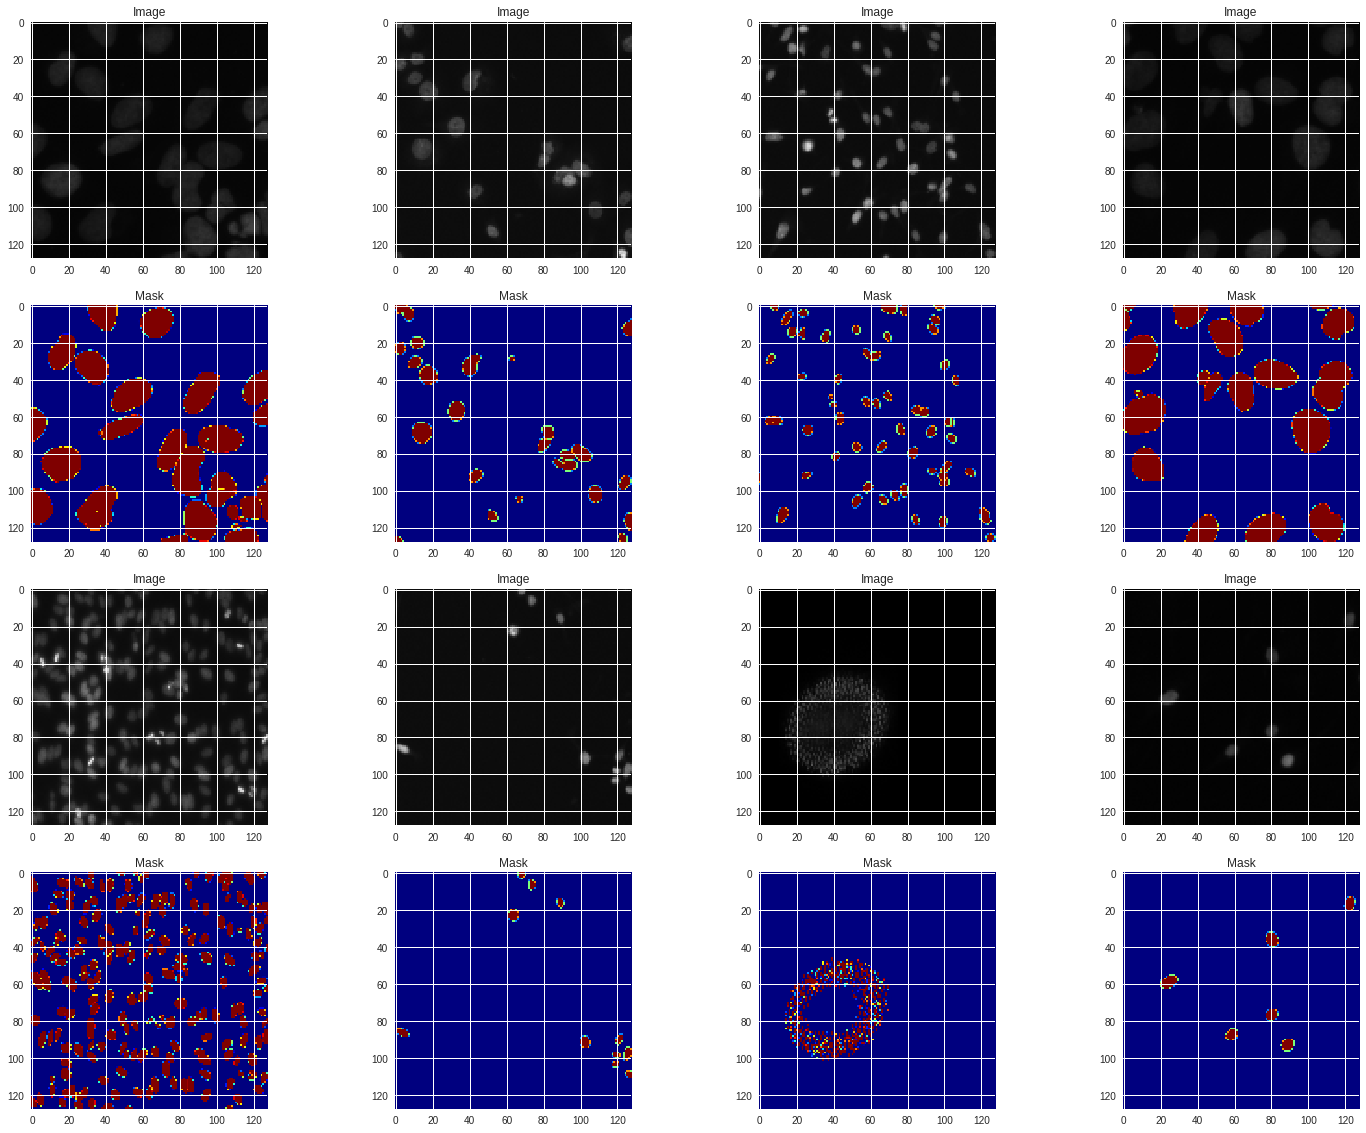

In [22]:
matplotlib.rcParams['figure.figsize'] = (25.0, 20.0)
plt.subplot(4,4,1)
plt.title("Image")
plt.imshow(X[0], cmap='jet')
plt.subplot(4,4,1+4)
plt.title("Mask")
plt.imshow(Y_squeezed[0], cmap='jet')
plt.subplot(4,4,2)
plt.title("Image")
plt.imshow(X[1], cmap='jet')
plt.subplot(4,4,2+4)
plt.title("Mask")
plt.imshow(Y_squeezed[1], cmap='jet')
plt.subplot(4,4,3)
plt.title("Image")
plt.imshow(X[2], cmap='jet')
plt.subplot(4,4,3+4)
plt.title("Mask")
plt.imshow(Y_squeezed[2], cmap='jet')
plt.subplot(4,4,4)
plt.title("Image")
plt.imshow(X[3], cmap='jet')
plt.subplot(4,4,4+4)
plt.title("Mask")
plt.imshow(Y_squeezed[3], cmap='jet')
plt.subplot(4,4,9)
plt.title("Image")
plt.imshow(X[4], cmap='jet')
plt.subplot(4,4,1+12)
plt.title("Mask")
plt.imshow(Y_squeezed[4], cmap='jet')
plt.subplot(4,4,10)
plt.title("Image")
plt.imshow(X[5], cmap='jet')
plt.subplot(4,4,2+12)
plt.title("Mask")
plt.imshow(Y_squeezed[5], cmap='jet')
plt.subplot(4,4,11)
plt.title("Image")
plt.imshow(X[6], cmap='jet')
plt.subplot(4,4,3+12)
plt.title("Mask")
plt.imshow(Y_squeezed[6], cmap='jet')
plt.subplot(4,4,12)
plt.title("Image")
plt.imshow(X[7], cmap='jet')
plt.subplot(4,4,4+12)
plt.title("Mask")
plt.imshow(Y_squeezed[7], cmap='jet')
plt.show()

# Create functions for encoding predicted mask as defined in the competition

**A function to encode flattened mask**

In [0]:
def encode_pixels(pixels, stepsize = 1): 
  
    '''A function to encode flattened mask'''
    
    consecutive_series = np.split(pixels, np.where(np.diff(pixels) != stepsize)[0]+1)
    
    encoded_series = []
    
    for series in consecutive_series:
        
        if len(series) > 0:
          first_elem = str(series[0])
          second_elem = str(len(series))
          encoded_series.append(first_elem)
          encoded_series.append(second_elem) 
          
    return " ".join(encoded_series)

**A function to encode a single maks**

In [0]:
def encode_single_mask(mask):
  
    '''A function to encode a single maks'''
  
    flattened_mask = mask.flatten(order = 'F')
    non_zero_elems = np.where(flattened_mask == 1)[0] + 1
#     non_zero_elems = np.where(flattened_mask == 0)[0] + 1
    
    encoded_pixels = encode_pixels(non_zero_elems, stepsize = 1)
    
    return encoded_pixels

**A function to encode a batch of masks**

In [0]:
def encode_masks(masks, shapes, threshold = 0.5):
  
    '''A function to encode a batch of masks'''
  
    encoded_labels = []
  
    mask_squeezed = np.squeeze(masks)
    
    for n in range(masks.shape[0]):
      
        mask = masks[n]
        
        mask = (mask - mask.min())/(mask.max() - mask.min())
        
        mask_resized = resize(mask, (shapes[n][0], shapes[n][1]), mode='constant')
        
        mask_binirized = np.where(mask_resized>threshold, 1, 0)
        
        encoded_labels.append(encode_single_mask(mask_binirized))
        
    return encoded_labels 

**Test the encode_masks function using the generated samples**

In [0]:
encoded_masks = encode_masks(Y, shapes)

In [27]:
encoded_masks[0]

'158 50 283 49 517 52 642 51 876 53 1001 52 1236 53 1360 53 1596 53 1720 53 1956 52 2080 55 2317 50 2439 56 2677 49 2799 57 3038 48 3159 57 3398 47 3519 57 3759 45 3879 57 4119 45 4239 57 4480 43 4599 57 4841 42 4960 55 5203 36 5278 1 5320 54 5564 34 5637 3 5682 51 5924 34 5996 5 6042 51 6286 30 6352 19 6402 51 6647 28 6712 19 6762 51 7008 26 7071 21 7123 49 7369 21 7428 27 7483 47 7730 20 7787 29 7844 46 8091 14 8146 32 8206 43 8455 8 8505 35 8568 39 8864 36 8928 39 9075 12 9223 37 9290 36 9434 14 9583 38 9651 34 9793 16 9942 40 10011 33 10149 24 10301 42 10376 26 10508 26 10660 44 10736 26 10868 27 11020 45 11097 24 11225 31 11380 46 11464 15 11584 33 11739 48 11825 14 11943 34 12098 50 12186 12 12303 36 12458 50 12663 36 12818 50 13022 37 13178 51 13380 39 13538 53 13740 39 13898 53 14098 41 14258 53 14457 42 14618 53 14816 43 14977 54 15171 48 15337 52 15529 50 15696 52 15888 51 16055 53 16247 52 16415 53 16606 53 16775 53 16966 53 17135 53 17326 53 17495 53 17686 52 17855 53 18046

In [28]:
encoded_masks[1]

'1 4 44 8 251 11 299 10 507 15 555 11 763 16 810 12 1019 16 1065 14 1276 15 1321 14 1532 14 1577 14 1789 13 1833 14 2046 12 2089 13 2303 1 2305 12 2346 11 2561 14 2604 8 2817 15 2862 4 3073 16 3330 15 3587 15 3646 6 3843 15 3901 8 4100 13 4155 10 4356 13 4391 6 4410 11 4613 11 4645 9 4665 12 4743 8 4870 9 4901 11 4921 12 4997 11 5156 13 5176 13 5251 15 5412 13 5432 13 5506 17 5668 13 5688 13 5761 19 5924 13 5944 13 6017 20 6180 12 6201 11 6272 21 6436 12 6457 11 6528 22 6692 11 6713 10 6729 6 6784 22 6948 11 6970 8 6983 10 7040 23 7205 10 7227 4 7238 13 7296 23 7462 8 7493 15 7552 23 7719 6 7748 17 7808 23 8003 19 8064 23 8259 20 8321 21 8515 20 8577 21 8770 21 8833 20 9026 21 9089 19 9282 21 9346 17 9538 21 9603 15 9795 20 9860 13 10051 19 10118 9 10308 18 10565 16 10822 15 11079 14 11337 11 11595 7 14705 6 14959 10 15213 14 15467 17 15723 18 15978 19 16234 19 16489 21 16745 21 17001 21 17257 21 17513 20 17769 20 18026 19 18283 17 18497 6 18540 15 18751 10 18797 13 19005 14 19054 9 19

In [29]:
encoded_masks[2]

'183 9 439 9 1661 3 1916 5 2109 3 2171 7 2363 6 2426 9 2616 9 2682 9 2871 10 2937 10 3073 2 3126 11 3193 10 3329 4 3382 10 3449 10 3585 5 3638 9 3705 10 3841 5 3895 6 3961 10 4097 6 4152 3 4217 10 4353 6 4473 10 4609 6 4729 10 4865 5 4985 10 5093 6 5122 1 5241 10 5345 12 5497 10 5599 14 5754 8 5853 16 6011 7 6108 17 6162 4 6268 5 6363 18 6416 7 6526 3 6619 17 6670 9 6875 16 6924 11 7131 15 7178 13 7387 13 7433 13 7644 11 7688 13 7901 8 7944 12 7963 6 8158 6 8199 12 8218 9 8455 10 8473 10 8711 8 8729 11 8967 7 8985 11 9241 11 9497 11 9753 10 10009 9 10267 4 10761 2 10783 3 10828 5 11015 5 11038 5 11083 6 11270 7 11293 6 11339 7 11526 7 11547 9 11595 7 11781 9 11801 13 11851 7 11959 5 12037 9 12057 14 12107 7 12167 2 12214 7 12293 8 12313 13 12363 6 12421 6 12469 8 12549 8 12570 11 12619 6 12676 8 12725 8 12806 7 12877 2 12931 10 12982 7 13063 6 13187 10 13238 7 13320 3 13443 11 13493 7 13699 11 13749 7 13955 10 14005 6 14211 10 14261 5 14468 8 14725 5 17187 4 17441 7 17695 10 17949 12 1

In [30]:
encoded_masks[3]

'2 38 66 33 162 28 361 39 426 33 520 31 721 39 785 35 879 33 1081 39 1143 39 1236 37 1441 38 1503 39 1596 38 1801 37 1862 41 1955 40 2161 37 2220 45 2313 42 2521 9 2532 25 2580 45 2673 42 2881 9 2897 19 2939 46 3031 46 3241 9 3258 17 3297 48 3390 48 3601 8 3618 16 3657 48 3750 48 3961 8 3983 7 4015 50 4108 50 4321 7 4346 3 4374 51 4467 51 4681 6 4707 1 4734 51 4827 51 5041 6 5092 53 5185 53 5272 21 5401 6 5452 53 5544 54 5632 22 5761 5 5811 55 5904 54 5991 24 6121 3 6169 58 6251 4 6264 54 6347 32 6481 3 6529 59 6610 6 6624 54 6706 34 6842 1 6889 58 6971 6 6984 54 7065 36 7249 56 7331 6 7344 54 7424 39 7609 56 7691 8 7704 54 7783 41 7968 57 8051 10 8064 54 8142 43 8326 59 8411 67 8501 44 8686 59 8771 67 8860 45 9046 59 9131 65 9219 46 9406 59 9490 65 9578 47 9766 58 9851 64 9938 48 10126 57 10212 63 10298 49 10486 56 10573 6 10581 54 10658 50 10846 56 10934 5 10941 54 11017 51 11206 56 11299 56 11377 51 11566 56 11659 56 11736 52 11926 54 12019 56 12097 51 12286 54 12379 56 12457 51 126

# Create UNET

## Variables and Placeholders

**Placeholders for input and output data**

In [0]:
# placeholder of input image
x = tf.placeholder(tf.float32, [None, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
# placeholder of mask
y = tf.placeholder(tf.float32, [None, IMG_HEIGHT, IMG_WIDTH, 1])
# placeholder for batch size
batchsize = tf.placeholder(tf.int32)

**Weights for convolutional operations for downsampleing and upsampling stages of UNET**

In [0]:
weights = {
'w11': tf.Variable(tf.random_normal([3,3,3,64],mean=0.0,stddev=0.02)),
'w12': tf.Variable(tf.random_normal([3,3,64,64],mean=0.0,stddev=0.02)),
'w21': tf.Variable(tf.random_normal([3,3,64,128],mean=0.0,stddev=0.02)),
'w22': tf.Variable(tf.random_normal([3,3,128,128],mean=0.0,stddev=0.02)),
'w31': tf.Variable(tf.random_normal([3,3,128,256],mean=0.0,stddev=0.02)),
'w32': tf.Variable(tf.random_normal([3,3,256,256],mean=0.0,stddev=0.02)),
'w41': tf.Variable(tf.random_normal([3,3,256,512],mean=0.0,stddev=0.02)),
'w42': tf.Variable(tf.random_normal([3,3,512,512],mean=0.0,stddev=0.02)),
'w51': tf.Variable(tf.random_normal([3,3,512,1024],mean=0.0,stddev=0.02)),
'w52': tf.Variable(tf.random_normal([3,3,1024,1024],mean=0.0,stddev=0.02)),
'wu1': tf.Variable(tf.random_normal([3,3,1024,1024],mean=0.0,stddev=0.02)),
'wu2': tf.Variable(tf.random_normal([3,3,512,1024],mean=0.0,stddev=0.02)),
'wu3': tf.Variable(tf.random_normal([3,3,256,512],mean=0.0,stddev=0.02)),
'wu4': tf.Variable(tf.random_normal([3,3,128,256],mean=0.0,stddev=0.02)),
'wf': tf.Variable(tf.random_normal([1,1,128,1],mean=0.0,stddev=0.02))
}

**Corresponding biases for the convolutional operations**

In [0]:
biases = {
'b11': tf.Variable(tf.random_normal([64],mean=0.0,stddev=0.02)),
'b12': tf.Variable(tf.random_normal([64],mean=0.0,stddev=0.02)),
'b21': tf.Variable(tf.random_normal([128],mean=0.0,stddev=0.02)),
'b22': tf.Variable(tf.random_normal([128],mean=0.0,stddev=0.02)),
'b31': tf.Variable(tf.random_normal([256],mean=0.0,stddev=0.02)),
'b32': tf.Variable(tf.random_normal([256],mean=0.0,stddev=0.02)),
'b41': tf.Variable(tf.random_normal([512],mean=0.0,stddev=0.02)),
'b42': tf.Variable(tf.random_normal([512],mean=0.0,stddev=0.02)),
'b51': tf.Variable(tf.random_normal([1024],mean=0.0,stddev=0.02)),
'b52': tf.Variable(tf.random_normal([1024],mean=0.0,stddev=0.02)),
'bu1': tf.Variable(tf.random_normal([1024],mean=0.0,stddev=0.02)),
'bu2': tf.Variable(tf.random_normal([512],mean=0.0,stddev=0.02)),
'bu3': tf.Variable(tf.random_normal([256],mean=0.0,stddev=0.02)),
'bu4': tf.Variable(tf.random_normal([128],mean=0.0,stddev=0.02)),
'bf': tf.Variable(tf.random_normal([1],mean=0.0,stddev=0.02))
}

## Downsampling stage

**A function for downsampling**

In [0]:
def down_sample(x,w1,b1,w2,b2,pool=True):
  
    with tf.device("/device:GPU:0"):
        x = tf.nn.conv2d(x,w1,strides=[1,1,1,1],padding='SAME')
        x = tf.nn.bias_add(x,b1)
        x = tf.nn.relu(x)
        x = tf.nn.conv2d(x,w2,strides=[1,1,1,1],padding='SAME')
        x = tf.nn.bias_add(x,b2)
        x = tf.nn.relu(x)
    if pool:
        with tf.device("/device:GPU:0"):
            y = tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
        return y,x
    else:
        return x

**Series of downsampling convolutional operations**

In [35]:
out1,res1 = down_sample(x,weights['w11'],biases['b11'],weights['w12'],biases['b12'], pool=True)
out1

<tf.Tensor 'MaxPool:0' shape=(?, 64, 64, 64) dtype=float32>

In [36]:
out1,res1 = down_sample(out1,weights['w21'],biases['b21'],weights['w22'],biases['b22'], pool=True)
out1

<tf.Tensor 'MaxPool_1:0' shape=(?, 32, 32, 128) dtype=float32>

In [37]:
out1,res1 = down_sample(out1,weights['w31'],biases['b31'],weights['w32'],biases['b32'], pool=True)
out1

<tf.Tensor 'MaxPool_2:0' shape=(?, 16, 16, 256) dtype=float32>

In [38]:
out1,res1 = down_sample(out1,weights['w41'],biases['b41'],weights['w42'],biases['b42'], pool=True)
out1

<tf.Tensor 'MaxPool_3:0' shape=(?, 8, 8, 512) dtype=float32>

In [39]:
out1 = down_sample(out1,weights['w51'],biases['b51'],weights['w52'],biases['b52'], pool=False)
out1

<tf.Tensor 'Relu_9:0' shape=(?, 8, 8, 1024) dtype=float32>

## Upsampling stage

**A function for upsampling**

In [0]:
def up_sample(x,w,b):
  
    output_shape = x.get_shape().as_list()
    output_shape[0] = batchsize
    output_shape[1] *= 2
    output_shape[2] *= 2
    output_shape[1] = np.int(output_shape[1])
    output_shape[2] = np.int(output_shape[2])
    output_shape[3] = w.get_shape().as_list()[2]
    with tf.device("/device:GPU:0"):
        conv_tf = tf.nn.conv2d_transpose(value=x,filter=w,output_shape=output_shape,strides= [1,2,2,1],padding="SAME")
        conv_tf = tf.nn.bias_add(conv_tf,b)
        conv_tf = tf.nn.relu(conv_tf)
    return conv_tf

**Series of upsampling convolutional operations**

In [41]:
up1 = up_sample(out1,weights['wu1'],biases['bu1'])
up1

<tf.Tensor 'Relu_10:0' shape=(?, 16, 16, 1024) dtype=float32>

In [42]:
up1 = up_sample(up1,weights['wu2'],biases['bu2'])
up1

<tf.Tensor 'Relu_11:0' shape=(?, 32, 32, 512) dtype=float32>

In [43]:
up1 = up_sample(up1,weights['wu3'],biases['bu3'])
up1

<tf.Tensor 'Relu_12:0' shape=(?, 64, 64, 256) dtype=float32>

In [44]:
up1 = up_sample(up1,weights['wu4'],biases['bu4'])
up1

<tf.Tensor 'Relu_13:0' shape=(?, 128, 128, 128) dtype=float32>

**Final convolutional layer**

In [45]:
with tf.device("/device:GPU:0"):
    out = tf.nn.conv2d(up1,weights['wf'],strides=[1,1,1,1],padding='SAME')
    out = tf.nn.bias_add(out,biases['bf'])
    out_sigmoid = tf.nn.sigmoid(out)
out

<tf.Tensor 'BiasAdd_14:0' shape=(?, 128, 128, 1) dtype=float32>

## Flatten convolutional layer and loss operation

**A fuction for flattening convolutional output**

In [0]:
def create_flatten_layer(layer):
    
    '''a function for creating flattened layer from convolutional output'''
    
    # extract the shape of the layer
    layer_shape = layer.get_shape()
    # calculate the number features of the flattened layer
    num_features = layer_shape[1:4].num_elements()
    # create the flattened layer
    layer = tf.reshape(layer, [-1, num_features])
    # return the layer
    return layer

**Flatten final convolutional output** 

In [47]:
flat_out = create_flatten_layer(out)
flat_out

<tf.Tensor 'Reshape:0' shape=(?, 16384) dtype=float32>

**Flatten mask images**

In [48]:
flat_labels = create_flatten_layer(y)
flat_labels

<tf.Tensor 'Reshape_1:0' shape=(?, 16384) dtype=float32>

**Create loss operation**

In [0]:
with tf.device("/device:GPU:0"):  
    loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=flat_labels, logits=flat_out)
#     cross_entropies = tf.nn.sigmoid_cross_entropy_with_logits(logits=flat_out, labels=flat_labels)
#     loss = tf.reduce_mean(cross_entropies)

**Create train step**

In [0]:
learning_rate=0.001*0.6
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
with tf.device("/device:GPU:0"):
    train_step = optimizer.minimize(loss)

# Train Model

**Randomly choosing the train and validation indices**

In [51]:
train_indices = np.random.choice(len(train_ids), round(len(train_ids)*0.94), replace=False)
validation_indices = np.array(list(set(range(len(train_ids))) - set(train_indices)))
print("Size of train set:", len(train_indices))
print("Size of validation set:", len(validation_indices))

Size of train set: 630
Size of validation set: 40


**Create feed dict for the validation set**

In [0]:
image_validation, mask_validation, shapes_validation = generate_batch(validation_indices)
feed_dict_validation =  {x: image_validation, y: mask_validation, batchsize: len(validation_indices)}

In [53]:
print("image_validation shape", image_validation.shape)
print("mask_validation shape", mask_validation.shape)

image_validation shape (40, 128, 128, 3)
mask_validation shape (40, 128, 128, 1)


In [0]:
# lists to store the train loss, validation loss, validation accuracy at each iteration
train_loss = []
valid_loss = []

# batch size
batch_size = 40
# max iteration
max_iter = 10000

**Train the model for designated number of hours and save the best model**

In [55]:
# create a saver object
saver = tf.train.Saver(max_to_keep=1)

# variables to store the accuracy, loss, iteration of our best model
best_loss = 100
best_iteration = None

iteration = 0

t1 = time.time()

# number of training hours
train_hours = 2.0

# create a graph session and optimize under it
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    # iterate for designated number of train hours
    while (time.time()-t1) < train_hours*60*60:
        
        # break if max iteration is reached
        if iteration >= max_iter:
            break
        
        # randomly generate the index of the batch
        batch_indices = np.random.choice(train_indices, size=batch_size)
        
        # generate data for the batch
        image_batch, mask_batch, shapes_batch = generate_batch(batch_indices)
        
        # feed dict of the batch
        feed_dict_batch =  {x: image_batch, y: mask_batch, batchsize: batch_size}
        
        # execute optimization step
        sess.run(train_step, feed_dict=feed_dict_batch)
        
        # calculate temporary train loss and append it to the designated list
        temp_train_loss = loss.eval(session=sess, feed_dict=feed_dict_batch)
        train_loss.append(temp_train_loss)
        
        # calculate temporary validation loss and append it to the designated list
        temp_validation_loss = loss.eval(session=sess, feed_dict=feed_dict_validation)
        valid_loss.append(temp_validation_loss)
        
        # if valid loss is better than best recorded so far then
        # update the parameters of the best model and save the model
        if temp_validation_loss < best_loss:
            best_loss = temp_validation_loss
            best_iteration = iteration          
            saver.save(sess, './my-model', global_step = best_iteration)
            
        # print metric info
        print("iterations:",iteration,
              "| train_loss:", temp_train_loss,
              "| validation_loss:", temp_validation_loss,
              "| Time elapsed:",str(datetime.timedelta(seconds=time.time()-t1)))
              
        # increment iteration
        iteration = iteration+1

iterations: 0 | train_loss: 0.69944555 | validation_loss: 0.6995601 | Time elapsed: 0:00:18.653021
iterations: 1 | train_loss: 0.6818148 | validation_loss: 0.6810579 | Time elapsed: 0:00:31.990482
iterations: 2 | train_loss: 0.5309299 | validation_loss: 0.52100885 | Time elapsed: 0:00:46.478475
iterations: 3 | train_loss: 1.6204233 | validation_loss: 1.481795 | Time elapsed: 0:00:59.352540
iterations: 4 | train_loss: 0.46704498 | validation_loss: 0.48551768 | Time elapsed: 0:01:11.788925
iterations: 5 | train_loss: 0.6135707 | validation_loss: 0.60867536 | Time elapsed: 0:01:22.611145
iterations: 6 | train_loss: 0.67029965 | validation_loss: 0.6697785 | Time elapsed: 0:01:30.537221
iterations: 7 | train_loss: 0.68722 | validation_loss: 0.68621445 | Time elapsed: 0:01:42.289558
iterations: 8 | train_loss: 0.691236 | validation_loss: 0.69113547 | Time elapsed: 0:01:51.714076
iterations: 9 | train_loss: 0.69277734 | validation_loss: 0.69276726 | Time elapsed: 0:02:03.849330
iterations: 10

iterations: 44 | train_loss: 0.44316474 | validation_loss: 0.42046863 | Time elapsed: 0:08:08.773759
iterations: 45 | train_loss: 0.38956442 | validation_loss: 0.42078823 | Time elapsed: 0:08:17.428650
iterations: 46 | train_loss: 0.401534 | validation_loss: 0.41829452 | Time elapsed: 0:08:26.811014
iterations: 47 | train_loss: 0.4618825 | validation_loss: 0.41466135 | Time elapsed: 0:08:39.790712
iterations: 48 | train_loss: 0.4115208 | validation_loss: 0.41643944 | Time elapsed: 0:08:48.597619
iterations: 49 | train_loss: 0.48123273 | validation_loss: 0.42249647 | Time elapsed: 0:08:59.229322
iterations: 50 | train_loss: 0.4700349 | validation_loss: 0.42756286 | Time elapsed: 0:09:11.436987
iterations: 51 | train_loss: 0.4380125 | validation_loss: 0.42455047 | Time elapsed: 0:09:24.383530
iterations: 52 | train_loss: 0.37816614 | validation_loss: 0.4133455 | Time elapsed: 0:09:33.334916
iterations: 53 | train_loss: 0.38697916 | validation_loss: 0.41064006 | Time elapsed: 0:09:41.2087

iterations: 88 | train_loss: 0.43925038 | validation_loss: 0.40376702 | Time elapsed: 0:15:26.600690
iterations: 89 | train_loss: 0.4023424 | validation_loss: 0.40927094 | Time elapsed: 0:15:38.694644
iterations: 90 | train_loss: 0.33177224 | validation_loss: 0.4033475 | Time elapsed: 0:15:44.144988
iterations: 91 | train_loss: 0.41287476 | validation_loss: 0.3985613 | Time elapsed: 0:15:53.656484
iterations: 92 | train_loss: 0.3835184 | validation_loss: 0.39997545 | Time elapsed: 0:16:00.438980
iterations: 93 | train_loss: 0.34190232 | validation_loss: 0.41164953 | Time elapsed: 0:16:09.570516
iterations: 94 | train_loss: 0.3615659 | validation_loss: 0.42091513 | Time elapsed: 0:16:22.895072
iterations: 95 | train_loss: 0.40739757 | validation_loss: 0.4091815 | Time elapsed: 0:16:31.502600
iterations: 96 | train_loss: 0.4444108 | validation_loss: 0.39744434 | Time elapsed: 0:16:44.656744
iterations: 97 | train_loss: 0.36476472 | validation_loss: 0.4012062 | Time elapsed: 0:16:54.69784

iterations: 132 | train_loss: 0.44307128 | validation_loss: 0.39885345 | Time elapsed: 0:22:21.356890
iterations: 133 | train_loss: 0.40371424 | validation_loss: 0.40481132 | Time elapsed: 0:22:31.337611
iterations: 134 | train_loss: 0.41217643 | validation_loss: 0.4055364 | Time elapsed: 0:22:39.992190
iterations: 135 | train_loss: 0.40608865 | validation_loss: 0.40074915 | Time elapsed: 0:22:49.253900
iterations: 136 | train_loss: 0.42787537 | validation_loss: 0.39645034 | Time elapsed: 0:22:57.374651
iterations: 137 | train_loss: 0.37752643 | validation_loss: 0.39579025 | Time elapsed: 0:23:06.172080
iterations: 138 | train_loss: 0.4238019 | validation_loss: 0.3987632 | Time elapsed: 0:23:16.817638
iterations: 139 | train_loss: 0.40702257 | validation_loss: 0.39880896 | Time elapsed: 0:23:25.683361
iterations: 140 | train_loss: 0.41411036 | validation_loss: 0.39536688 | Time elapsed: 0:23:34.798960
iterations: 141 | train_loss: 0.39615172 | validation_loss: 0.39337134 | Time elapsed

iterations: 175 | train_loss: 0.33964938 | validation_loss: 0.35804766 | Time elapsed: 0:29:26.082711
iterations: 176 | train_loss: 0.31448197 | validation_loss: 0.35167423 | Time elapsed: 0:29:37.207963
iterations: 177 | train_loss: 0.40896648 | validation_loss: 0.3505261 | Time elapsed: 0:29:47.290194
iterations: 178 | train_loss: 0.38669896 | validation_loss: 0.35968858 | Time elapsed: 0:29:54.731853
iterations: 179 | train_loss: 0.33661416 | validation_loss: 0.34463322 | Time elapsed: 0:30:09.035406
iterations: 180 | train_loss: 0.43542776 | validation_loss: 0.34810716 | Time elapsed: 0:30:22.365597
iterations: 181 | train_loss: 0.354092 | validation_loss: 0.3415575 | Time elapsed: 0:30:31.372104
iterations: 182 | train_loss: 0.30806318 | validation_loss: 0.34668463 | Time elapsed: 0:30:41.758018
iterations: 183 | train_loss: 0.3070956 | validation_loss: 0.33573407 | Time elapsed: 0:30:55.746684
iterations: 184 | train_loss: 0.34014294 | validation_loss: 0.33499807 | Time elapsed: 

iterations: 218 | train_loss: 0.32846418 | validation_loss: 0.3280525 | Time elapsed: 0:36:17.014700
iterations: 219 | train_loss: 0.34732836 | validation_loss: 0.3246914 | Time elapsed: 0:36:24.129552
iterations: 220 | train_loss: 0.36294603 | validation_loss: 0.3242821 | Time elapsed: 0:36:37.487791
iterations: 221 | train_loss: 0.33059323 | validation_loss: 0.3173231 | Time elapsed: 0:36:44.599775
iterations: 222 | train_loss: 0.2975077 | validation_loss: 0.31215397 | Time elapsed: 0:36:52.543804
iterations: 223 | train_loss: 0.26585656 | validation_loss: 0.31253305 | Time elapsed: 0:37:01.337155
iterations: 224 | train_loss: 0.30827504 | validation_loss: 0.31079283 | Time elapsed: 0:37:14.269564
iterations: 225 | train_loss: 0.25971505 | validation_loss: 0.30930585 | Time elapsed: 0:37:24.439387
iterations: 226 | train_loss: 0.30487627 | validation_loss: 0.3122161 | Time elapsed: 0:37:32.306555
iterations: 227 | train_loss: 0.2147301 | validation_loss: 0.30674404 | Time elapsed: 0:

iterations: 261 | train_loss: 0.3156058 | validation_loss: 0.2935918 | Time elapsed: 0:43:17.510655
iterations: 262 | train_loss: 0.30681702 | validation_loss: 0.292772 | Time elapsed: 0:43:23.550645
iterations: 263 | train_loss: 0.24897094 | validation_loss: 0.28762078 | Time elapsed: 0:43:36.526211
iterations: 264 | train_loss: 0.24966402 | validation_loss: 0.28885156 | Time elapsed: 0:43:48.324098
iterations: 265 | train_loss: 0.27687854 | validation_loss: 0.28883034 | Time elapsed: 0:43:57.822441
iterations: 266 | train_loss: 0.20923844 | validation_loss: 0.2873302 | Time elapsed: 0:44:11.987580
iterations: 267 | train_loss: 0.29636237 | validation_loss: 0.289847 | Time elapsed: 0:44:20.457965
iterations: 268 | train_loss: 0.26494098 | validation_loss: 0.29159522 | Time elapsed: 0:44:30.731127
iterations: 269 | train_loss: 0.2681058 | validation_loss: 0.29541764 | Time elapsed: 0:44:40.364882
iterations: 270 | train_loss: 0.28196502 | validation_loss: 0.29322273 | Time elapsed: 0:4

iterations: 304 | train_loss: 0.22982351 | validation_loss: 0.27109542 | Time elapsed: 0:50:41.009296
iterations: 305 | train_loss: 0.25378817 | validation_loss: 0.26887256 | Time elapsed: 0:50:50.460924
iterations: 306 | train_loss: 0.2805926 | validation_loss: 0.2581703 | Time elapsed: 0:51:01.080053
iterations: 307 | train_loss: 0.29888496 | validation_loss: 0.25668168 | Time elapsed: 0:51:13.809883
iterations: 308 | train_loss: 0.21355605 | validation_loss: 0.26207435 | Time elapsed: 0:51:21.194487
iterations: 309 | train_loss: 0.21140747 | validation_loss: 0.2653691 | Time elapsed: 0:51:28.329363
iterations: 310 | train_loss: 0.26233214 | validation_loss: 0.26288873 | Time elapsed: 0:51:40.332782
iterations: 311 | train_loss: 0.24771003 | validation_loss: 0.25801018 | Time elapsed: 0:51:52.262733
iterations: 312 | train_loss: 0.2269247 | validation_loss: 0.25875503 | Time elapsed: 0:52:04.546475
iterations: 313 | train_loss: 0.23201351 | validation_loss: 0.2578422 | Time elapsed: 

iterations: 347 | train_loss: 0.1984081 | validation_loss: 0.23610921 | Time elapsed: 0:57:51.981001
iterations: 348 | train_loss: 0.1675004 | validation_loss: 0.23478496 | Time elapsed: 0:58:00.793361
iterations: 349 | train_loss: 0.23097739 | validation_loss: 0.23354296 | Time elapsed: 0:58:14.942497
iterations: 350 | train_loss: 0.23618162 | validation_loss: 0.23197234 | Time elapsed: 0:58:30.331449
iterations: 351 | train_loss: 0.1998842 | validation_loss: 0.23230703 | Time elapsed: 0:58:38.145456
iterations: 352 | train_loss: 0.18663728 | validation_loss: 0.23761436 | Time elapsed: 0:58:44.676173
iterations: 353 | train_loss: 0.19317897 | validation_loss: 0.23297326 | Time elapsed: 0:58:56.438984
iterations: 354 | train_loss: 0.18883249 | validation_loss: 0.23444048 | Time elapsed: 0:59:03.965289
iterations: 355 | train_loss: 0.22370538 | validation_loss: 0.23372383 | Time elapsed: 0:59:12.126893
iterations: 356 | train_loss: 0.22337699 | validation_loss: 0.23162022 | Time elapsed

iterations: 390 | train_loss: 0.18095024 | validation_loss: 0.22861035 | Time elapsed: 1:05:01.229401
iterations: 391 | train_loss: 0.19866483 | validation_loss: 0.2207609 | Time elapsed: 1:05:09.192228
iterations: 392 | train_loss: 0.18906762 | validation_loss: 0.22033577 | Time elapsed: 1:05:15.958588
iterations: 393 | train_loss: 0.15156636 | validation_loss: 0.2208058 | Time elapsed: 1:05:21.627078
iterations: 394 | train_loss: 0.22387055 | validation_loss: 0.22188881 | Time elapsed: 1:05:31.947171
iterations: 395 | train_loss: 0.20127186 | validation_loss: 0.21770525 | Time elapsed: 1:05:42.147941
iterations: 396 | train_loss: 0.20561974 | validation_loss: 0.21639657 | Time elapsed: 1:05:52.385669
iterations: 397 | train_loss: 0.1684605 | validation_loss: 0.2165753 | Time elapsed: 1:06:00.876813
iterations: 398 | train_loss: 0.15674603 | validation_loss: 0.21383846 | Time elapsed: 1:06:10.081315
iterations: 399 | train_loss: 0.19298175 | validation_loss: 0.21540637 | Time elapsed:

iterations: 433 | train_loss: 0.20069619 | validation_loss: 0.20399387 | Time elapsed: 1:11:47.859488
iterations: 434 | train_loss: 0.17798033 | validation_loss: 0.20580575 | Time elapsed: 1:12:00.856694
iterations: 435 | train_loss: 0.18009889 | validation_loss: 0.2039899 | Time elapsed: 1:12:12.336987
iterations: 436 | train_loss: 0.20679374 | validation_loss: 0.2119546 | Time elapsed: 1:12:21.015960
iterations: 437 | train_loss: 0.15599999 | validation_loss: 0.20419864 | Time elapsed: 1:12:28.646254
iterations: 438 | train_loss: 0.2039711 | validation_loss: 0.2083321 | Time elapsed: 1:12:38.305757
iterations: 439 | train_loss: 0.18542072 | validation_loss: 0.20397675 | Time elapsed: 1:12:49.229852
iterations: 440 | train_loss: 0.16295852 | validation_loss: 0.2032623 | Time elapsed: 1:12:57.777914
iterations: 441 | train_loss: 0.19765976 | validation_loss: 0.20228764 | Time elapsed: 1:13:10.133159
iterations: 442 | train_loss: 0.19660278 | validation_loss: 0.19987056 | Time elapsed: 

iterations: 476 | train_loss: 0.19129138 | validation_loss: 0.19252102 | Time elapsed: 1:18:53.164709
iterations: 477 | train_loss: 0.16847573 | validation_loss: 0.19229165 | Time elapsed: 1:19:08.965640
iterations: 478 | train_loss: 0.14418392 | validation_loss: 0.19300248 | Time elapsed: 1:19:19.065935
iterations: 479 | train_loss: 0.14343579 | validation_loss: 0.19475186 | Time elapsed: 1:19:27.162775
iterations: 480 | train_loss: 0.1447746 | validation_loss: 0.19099326 | Time elapsed: 1:19:38.519959
iterations: 481 | train_loss: 0.1684502 | validation_loss: 0.1931777 | Time elapsed: 1:19:47.865683
iterations: 482 | train_loss: 0.18851583 | validation_loss: 0.18918738 | Time elapsed: 1:20:00.724875
iterations: 483 | train_loss: 0.18854602 | validation_loss: 0.20042709 | Time elapsed: 1:20:13.843704
iterations: 484 | train_loss: 0.12850252 | validation_loss: 0.19116922 | Time elapsed: 1:20:20.945143
iterations: 485 | train_loss: 0.17963015 | validation_loss: 0.20077881 | Time elapsed

iterations: 519 | train_loss: 0.13350523 | validation_loss: 0.18391348 | Time elapsed: 1:25:59.570030
iterations: 520 | train_loss: 0.14865968 | validation_loss: 0.19531256 | Time elapsed: 1:26:10.637122
iterations: 521 | train_loss: 0.16641119 | validation_loss: 0.18540397 | Time elapsed: 1:26:20.097086
iterations: 522 | train_loss: 0.15892455 | validation_loss: 0.18248439 | Time elapsed: 1:26:30.949014
iterations: 523 | train_loss: 0.1367333 | validation_loss: 0.18700846 | Time elapsed: 1:26:39.535039
iterations: 524 | train_loss: 0.17028894 | validation_loss: 0.1859384 | Time elapsed: 1:26:49.177795
iterations: 525 | train_loss: 0.1802604 | validation_loss: 0.19138964 | Time elapsed: 1:26:58.977404
iterations: 526 | train_loss: 0.1684055 | validation_loss: 0.18417287 | Time elapsed: 1:27:10.026307
iterations: 527 | train_loss: 0.15993795 | validation_loss: 0.19459942 | Time elapsed: 1:27:23.063974
iterations: 528 | train_loss: 0.16097653 | validation_loss: 0.19001767 | Time elapsed:

iterations: 562 | train_loss: 0.12821907 | validation_loss: 0.17961136 | Time elapsed: 1:32:53.640569
iterations: 563 | train_loss: 0.11908303 | validation_loss: 0.1824279 | Time elapsed: 1:33:01.187874
iterations: 564 | train_loss: 0.14959106 | validation_loss: 0.17950079 | Time elapsed: 1:33:11.070547
iterations: 565 | train_loss: 0.12439071 | validation_loss: 0.17906025 | Time elapsed: 1:33:21.723048
iterations: 566 | train_loss: 0.14093581 | validation_loss: 0.17713498 | Time elapsed: 1:33:35.494024
iterations: 567 | train_loss: 0.14477906 | validation_loss: 0.17621711 | Time elapsed: 1:33:45.859670
iterations: 568 | train_loss: 0.12835737 | validation_loss: 0.17669703 | Time elapsed: 1:33:54.210583
iterations: 569 | train_loss: 0.1469365 | validation_loss: 0.17618766 | Time elapsed: 1:34:04.895119
iterations: 570 | train_loss: 0.15343733 | validation_loss: 0.17785433 | Time elapsed: 1:34:13.729230
iterations: 571 | train_loss: 0.17945802 | validation_loss: 0.17855684 | Time elapse

iterations: 605 | train_loss: 0.13009249 | validation_loss: 0.17983225 | Time elapsed: 1:40:05.576210
iterations: 606 | train_loss: 0.14887653 | validation_loss: 0.18056142 | Time elapsed: 1:40:14.779725
iterations: 607 | train_loss: 0.117509104 | validation_loss: 0.17893991 | Time elapsed: 1:40:25.566997
iterations: 608 | train_loss: 0.1464649 | validation_loss: 0.19150643 | Time elapsed: 1:40:34.986201
iterations: 609 | train_loss: 0.13553211 | validation_loss: 0.1748846 | Time elapsed: 1:40:44.119922
iterations: 610 | train_loss: 0.14107075 | validation_loss: 0.1812602 | Time elapsed: 1:40:56.538303
iterations: 611 | train_loss: 0.100929454 | validation_loss: 0.17480485 | Time elapsed: 1:41:03.001236
iterations: 612 | train_loss: 0.14870633 | validation_loss: 0.18253407 | Time elapsed: 1:41:14.544887
iterations: 613 | train_loss: 0.14067599 | validation_loss: 0.17660615 | Time elapsed: 1:41:24.590408
iterations: 614 | train_loss: 0.13427158 | validation_loss: 0.17857486 | Time elaps

iterations: 648 | train_loss: 0.091383725 | validation_loss: 0.1737193 | Time elapsed: 1:46:52.739838
iterations: 649 | train_loss: 0.12551236 | validation_loss: 0.17578283 | Time elapsed: 1:47:01.873633
iterations: 650 | train_loss: 0.1335519 | validation_loss: 0.17545977 | Time elapsed: 1:47:12.402836
iterations: 651 | train_loss: 0.123980165 | validation_loss: 0.1824232 | Time elapsed: 1:47:20.158472
iterations: 652 | train_loss: 0.13314961 | validation_loss: 0.17614529 | Time elapsed: 1:47:27.962509
iterations: 653 | train_loss: 0.107396625 | validation_loss: 0.17374077 | Time elapsed: 1:47:35.694472
iterations: 654 | train_loss: 0.11496304 | validation_loss: 0.17638016 | Time elapsed: 1:47:46.190165
iterations: 655 | train_loss: 0.15669021 | validation_loss: 0.17377082 | Time elapsed: 1:47:56.784507
iterations: 656 | train_loss: 0.12978077 | validation_loss: 0.17379233 | Time elapsed: 1:48:07.113456
iterations: 657 | train_loss: 0.13666205 | validation_loss: 0.18277636 | Time elap

iterations: 691 | train_loss: 0.10400017 | validation_loss: 0.17485033 | Time elapsed: 1:53:42.487757
iterations: 692 | train_loss: 0.11014117 | validation_loss: 0.17400327 | Time elapsed: 1:53:52.474992
iterations: 693 | train_loss: 0.10302591 | validation_loss: 0.17542705 | Time elapsed: 1:53:59.492545
iterations: 694 | train_loss: 0.09518832 | validation_loss: 0.1722217 | Time elapsed: 1:54:09.854986
iterations: 695 | train_loss: 0.113666914 | validation_loss: 0.1764923 | Time elapsed: 1:54:19.163641
iterations: 696 | train_loss: 0.11714997 | validation_loss: 0.1792059 | Time elapsed: 1:54:26.555018
iterations: 697 | train_loss: 0.12261312 | validation_loss: 0.17712344 | Time elapsed: 1:54:38.050804
iterations: 698 | train_loss: 0.12706256 | validation_loss: 0.17681256 | Time elapsed: 1:54:48.443419
iterations: 699 | train_loss: 0.102417864 | validation_loss: 0.17523536 | Time elapsed: 1:54:55.097666
iterations: 700 | train_loss: 0.099374264 | validation_loss: 0.17236918 | Time elap

**Plot train and validation loss throughout the iterations**

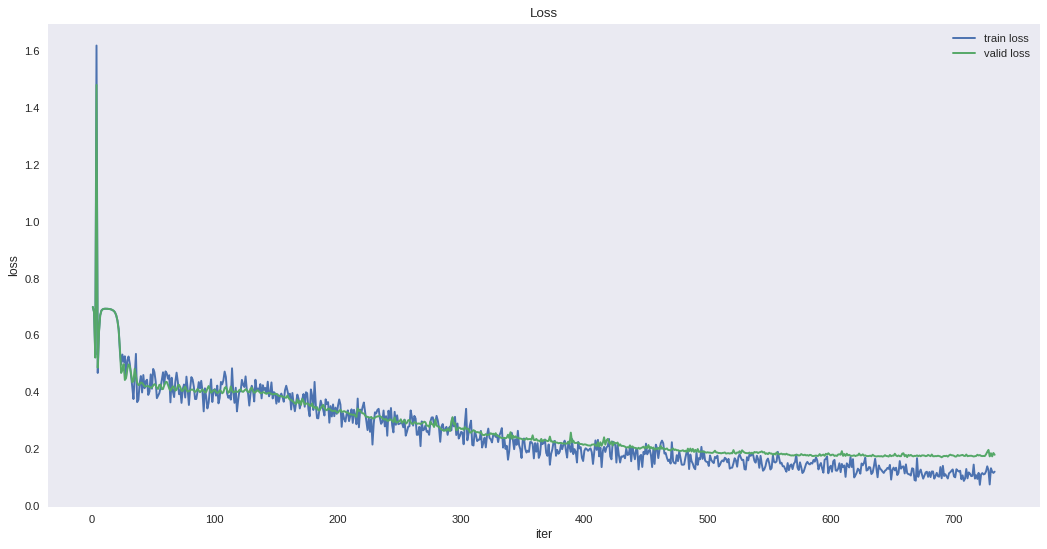

In [56]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
iterations = list(range(1,iteration+1))
plt.plot(iterations, train_loss, label = "train loss")
plt.plot(iterations, valid_loss, label = "valid loss")
plt.title("Loss")
plt.xlabel("iter")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.show()

# Visulalise sample prediction masks to help choosing the threshold to binirize

**Compute the predicted mask of the validation set**

In [57]:
with tf.Session() as sess:
  
    # restore the best model
    model_path = "./"+"my-model-"+str(best_iteration)
    saver.restore(sess, model_path)
    
    # compute the predicted mask of the validation set
    mask_predicted = sess.run(out, feed_dict=feed_dict_validation)

INFO:tensorflow:Restoring parameters from ./my-model-689


## Visualize some raw predicted mask 

In [0]:
def process_output_masks(masks, threshold = 0.5):
  
    masks_copy = masks.copy()
  
    # squeeze mask
    masks_squeezed = np.squeeze(masks_copy)
    
    # iterate throug each mask
    for n in range(masks_squeezed.shape[0]):
        # normalize mask            
        masks_squeezed[n] = (masks_squeezed[n] - masks_squeezed[n].min())/(masks_squeezed[n].max() - masks_squeezed[n].min())
        # binirize mask
        masks_squeezed[n] = np.where(masks_squeezed[n]>threshold, 1, 0)
        
    # return processed mask
    return masks_squeezed

In [0]:
mask_processed = process_output_masks(mask_predicted)

In [0]:
mask_validation_squeezed = np.squeeze(mask_validation)
mask_predicted_squeezed = np.squeeze(mask_predicted)

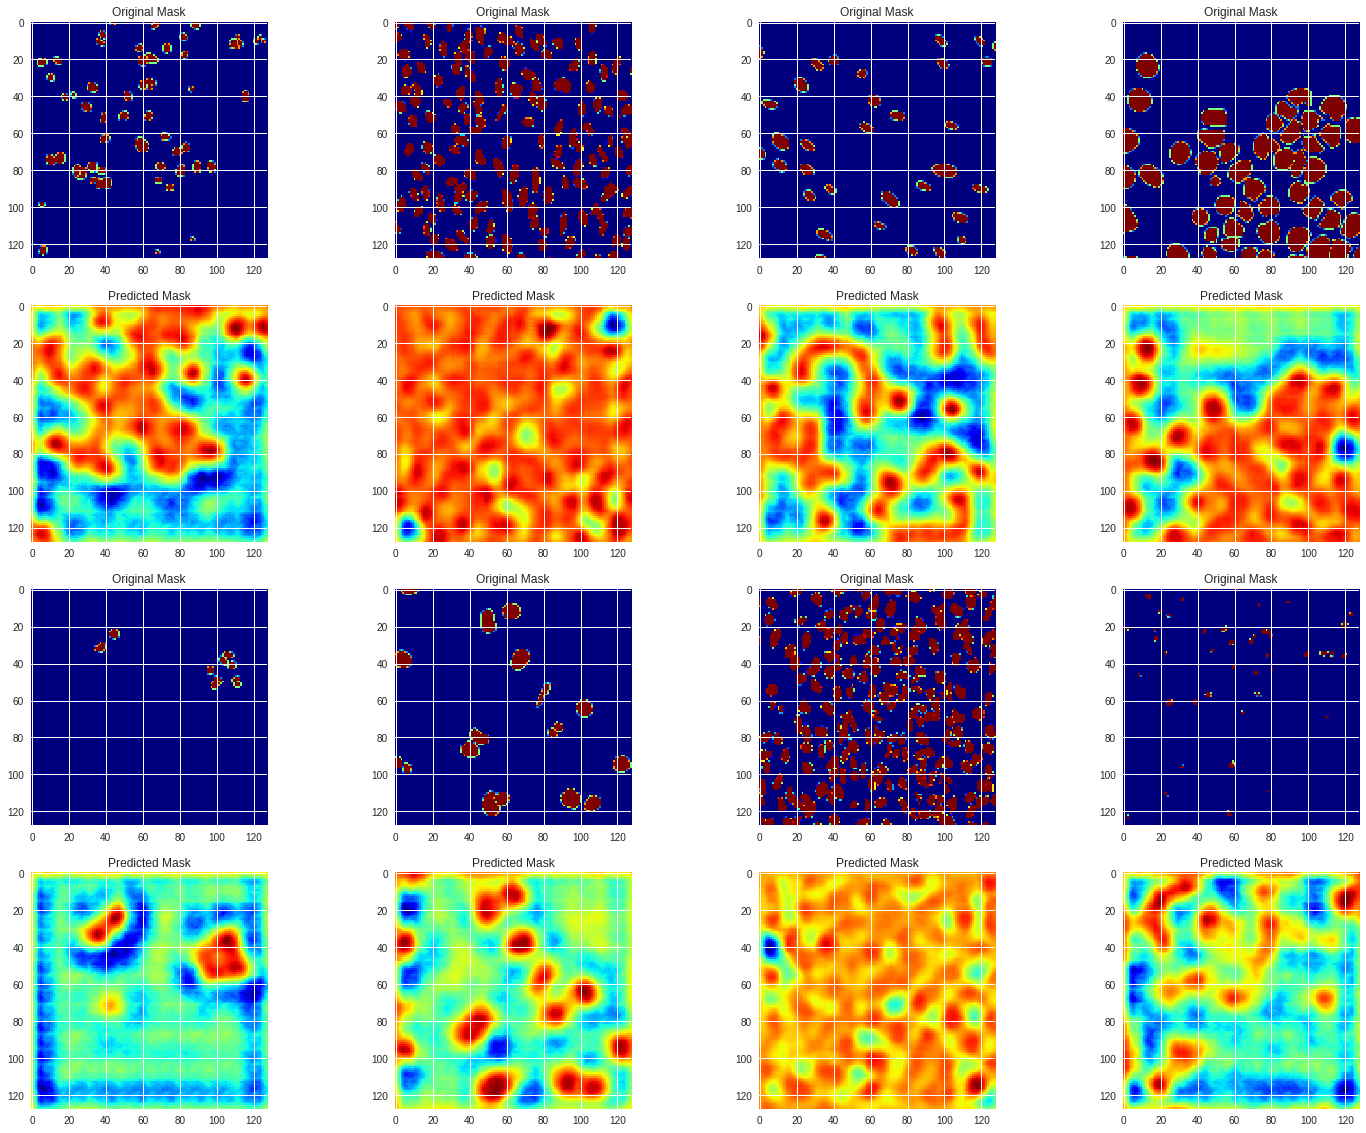

In [61]:
matplotlib.rcParams['figure.figsize'] = (25.0, 20.0)
plt.subplot(4,4,1)
plt.title("Original Mask")
plt.imshow(mask_validation_squeezed[0], cmap='jet')
plt.subplot(4,4,1+4)
plt.title("Predicted Mask")
plt.imshow(mask_predicted_squeezed[0],cmap='jet')
plt.subplot(4,4,2)
plt.title("Original Mask")
plt.imshow(mask_validation_squeezed[1],cmap='jet')
plt.subplot(4,4,2+4)
plt.title("Predicted Mask")
plt.imshow(mask_predicted_squeezed[1], cmap='jet')
plt.subplot(4,4,3)
plt.title("Original Mask")
plt.imshow(mask_validation_squeezed[2], cmap='jet')
plt.subplot(4,4,3+4)
plt.title("Predicted Mask")
plt.imshow(mask_predicted_squeezed[2], cmap='jet')
plt.subplot(4,4,4)
plt.title("Original Mask")
plt.imshow(mask_validation_squeezed[3], cmap='jet')
plt.subplot(4,4,4+4)
plt.title("Predicted Mask")
plt.imshow(mask_predicted_squeezed[3], cmap='jet')
plt.subplot(4,4,9)
plt.title("Original Mask")
plt.imshow(mask_validation_squeezed[4], cmap='jet')
plt.subplot(4,4,1+12)
plt.title("Predicted Mask")
plt.imshow(mask_predicted_squeezed[4], cmap='jet')
plt.subplot(4,4,10)
plt.title("Original Mask")
plt.imshow(mask_validation_squeezed[5], cmap='jet')
plt.subplot(4,4,2+12)
plt.title("Predicted Mask")
plt.imshow(mask_predicted_squeezed[5], cmap='jet')
plt.subplot(4,4,11)
plt.title("Original Mask")
plt.imshow(mask_validation_squeezed[6], cmap='jet')
plt.subplot(4,4,3+12)
plt.title("Predicted Mask")
plt.imshow(mask_predicted_squeezed[6], cmap='jet')
plt.subplot(4,4,12)
plt.title("Original Mask")
plt.imshow(mask_validation_squeezed[7], cmap='jet')
plt.subplot(4,4,4+12)
plt.title("Predicted Mask")
plt.imshow(mask_predicted_squeezed[7],cmap='jet')
plt.show()

## Visualize some processed predicted mask with different thresholds

**A function to normalize and binirize a batch of mask**

**A function to plot some sample images and predicted masks by passing a threshold**

In [0]:
def plot_true_predicted_mask(mask_true, mask_predicted, threshold, index):
  
    mask_true_squeezed = np.squeeze(mask_true)
    mask_predicted = process_output_masks(mask_predicted, threshold)  
    
    matplotlib.rcParams['figure.figsize'] = (25.0, 20.0)
    plt.subplot(4,4,1)
    plt.title("Original Mask")
    plt.imshow(mask_true_squeezed[index[0]], cmap='jet')
    plt.subplot(4,4,1+4)
    plt.title("Processed Predicted Mask")
    plt.imshow(mask_predicted[index[0]], cmap='jet')
    plt.subplot(4,4,2)
    plt.title("Original Mask")
    plt.imshow(mask_true_squeezed[index[1]], cmap='jet')
    plt.subplot(4,4,2+4)
    plt.title("Processed Predicted Mask")
    plt.imshow(mask_predicted[index[1]], cmap='jet')
    plt.subplot(4,4,3)
    plt.title("Original Mask")
    plt.imshow(mask_true_squeezed[index[2]], cmap='jet')
    plt.subplot(4,4,3+4)
    plt.title("Processed Predicted Mask")
    plt.imshow(mask_predicted[index[2]], cmap='jet')
    plt.subplot(4,4,4)
    plt.title("Original Mask")
    plt.imshow(mask_true_squeezed[index[3]], cmap='jet')
    plt.subplot(4,4,4+4)
    plt.title("Processed Predicted Mask")
    plt.imshow(mask_predicted[index[3]], cmap='jet')
    plt.subplot(4,4,9)
    plt.title("Original Mask")
    plt.imshow(mask_true_squeezed[index[4]], cmap='jet')
    plt.subplot(4,4,1+12)
    plt.title("Processed Predicted Mask")
    plt.imshow(mask_predicted[index[4]], cmap='jet')
    plt.subplot(4,4,10)
    plt.title("Original Mask")
    plt.imshow(mask_true_squeezed[index[5]], cmap='jet')
    plt.subplot(4,4,2+12)
    plt.title("Processed Predicted Mask")
    plt.imshow(mask_predicted[index[5]], cmap='jet')
    plt.subplot(4,4,11)
    plt.title("Original Mask")
    plt.imshow(mask_true_squeezed[index[6]], cmap='jet')
    plt.subplot(4,4,3+12)
    plt.title("Processed Predicted Mask")
    plt.imshow(mask_predicted[index[6]], cmap='jet')
    plt.subplot(4,4,12)
    plt.title("Original Mask")
    plt.imshow(mask_true_squeezed[index[7]], cmap='jet')
    plt.subplot(4,4,4+12)
    plt.title("Processed Predicted Mask")
    plt.imshow(mask_predicted[index[7]], cmap='jet')
    plt.show()

In [0]:
index = np.random.choice(range(mask_validation.shape[0]), size=16)

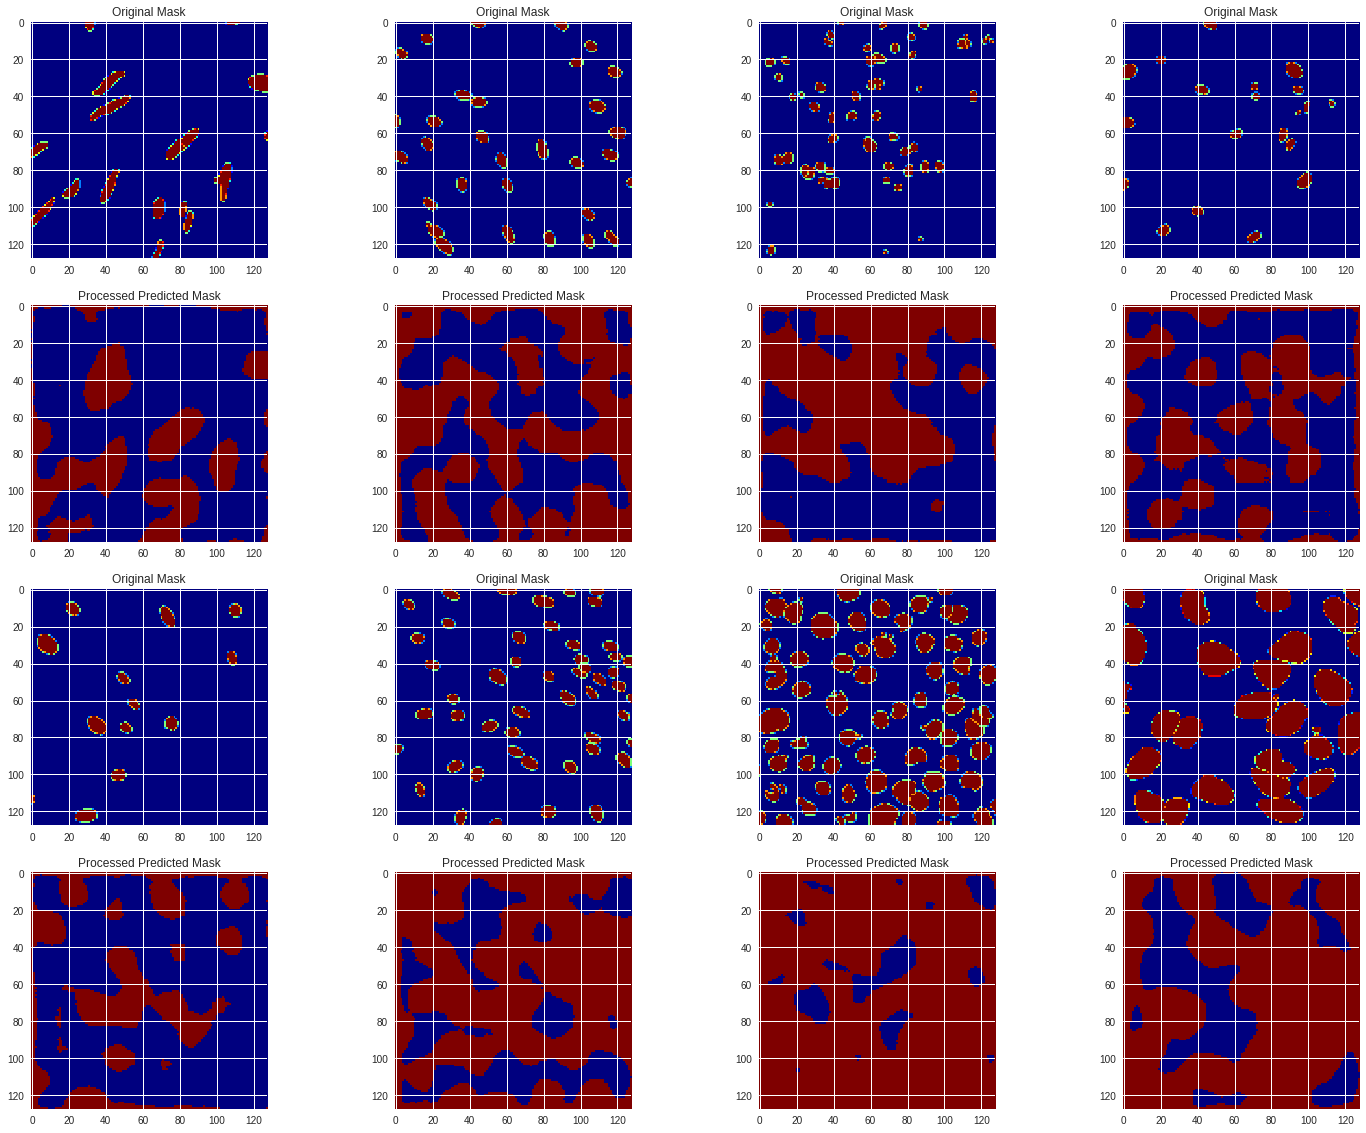

In [64]:
plot_true_predicted_mask(mask_validation, mask_predicted, 0.5, index)

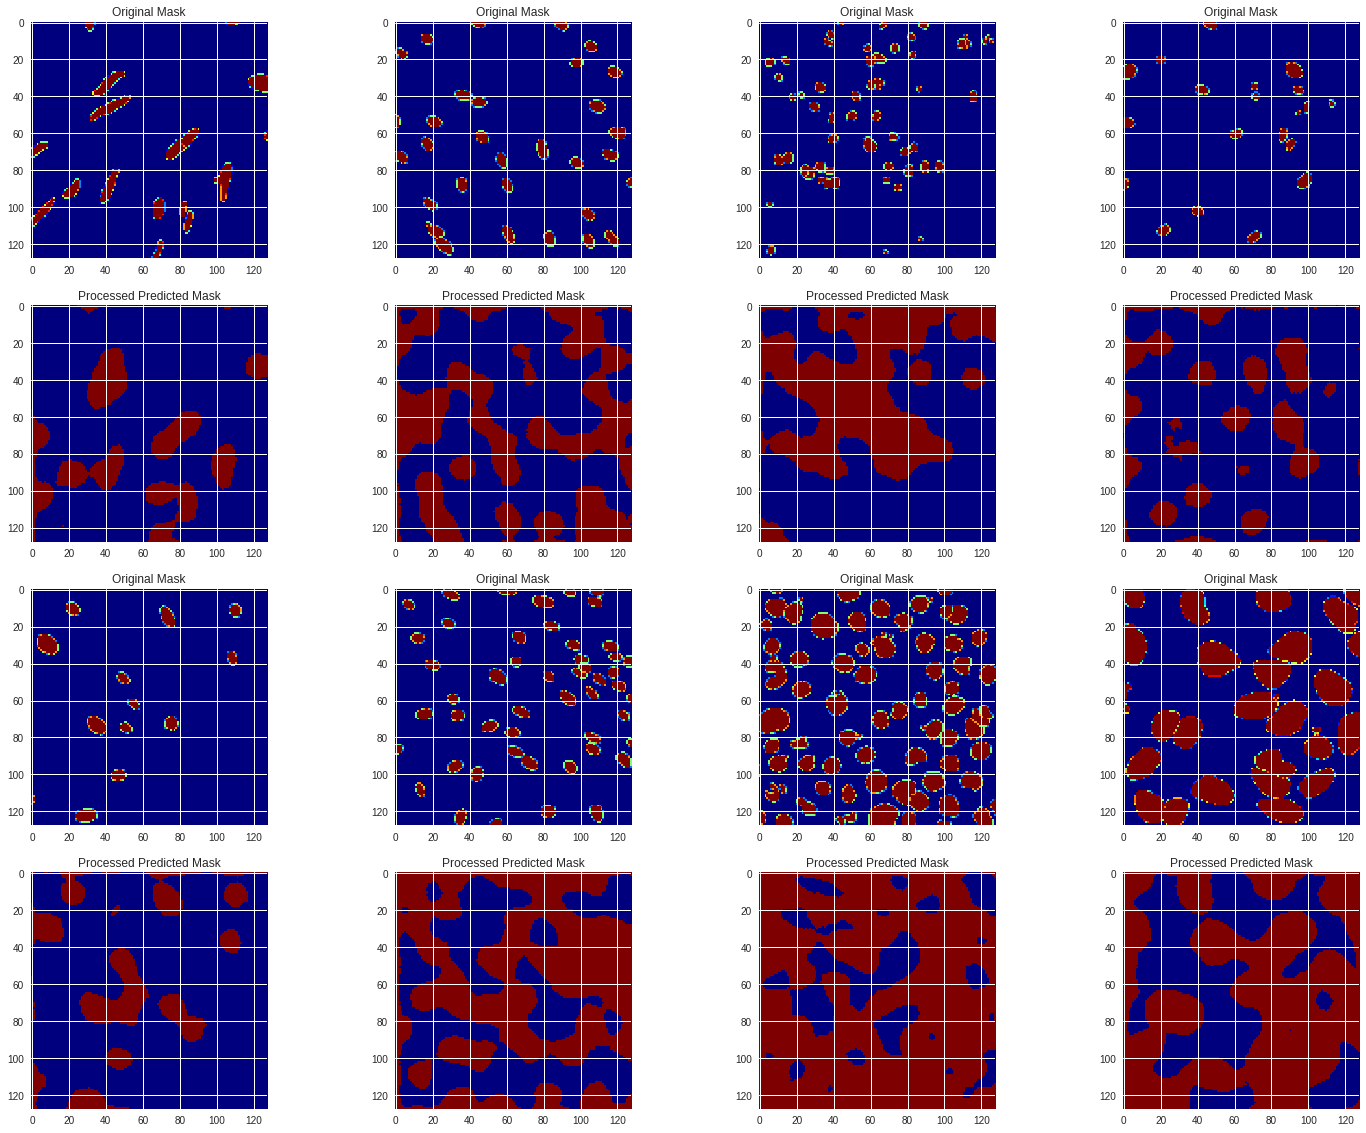

In [65]:
plot_true_predicted_mask(mask_validation, mask_predicted, 0.6, index)

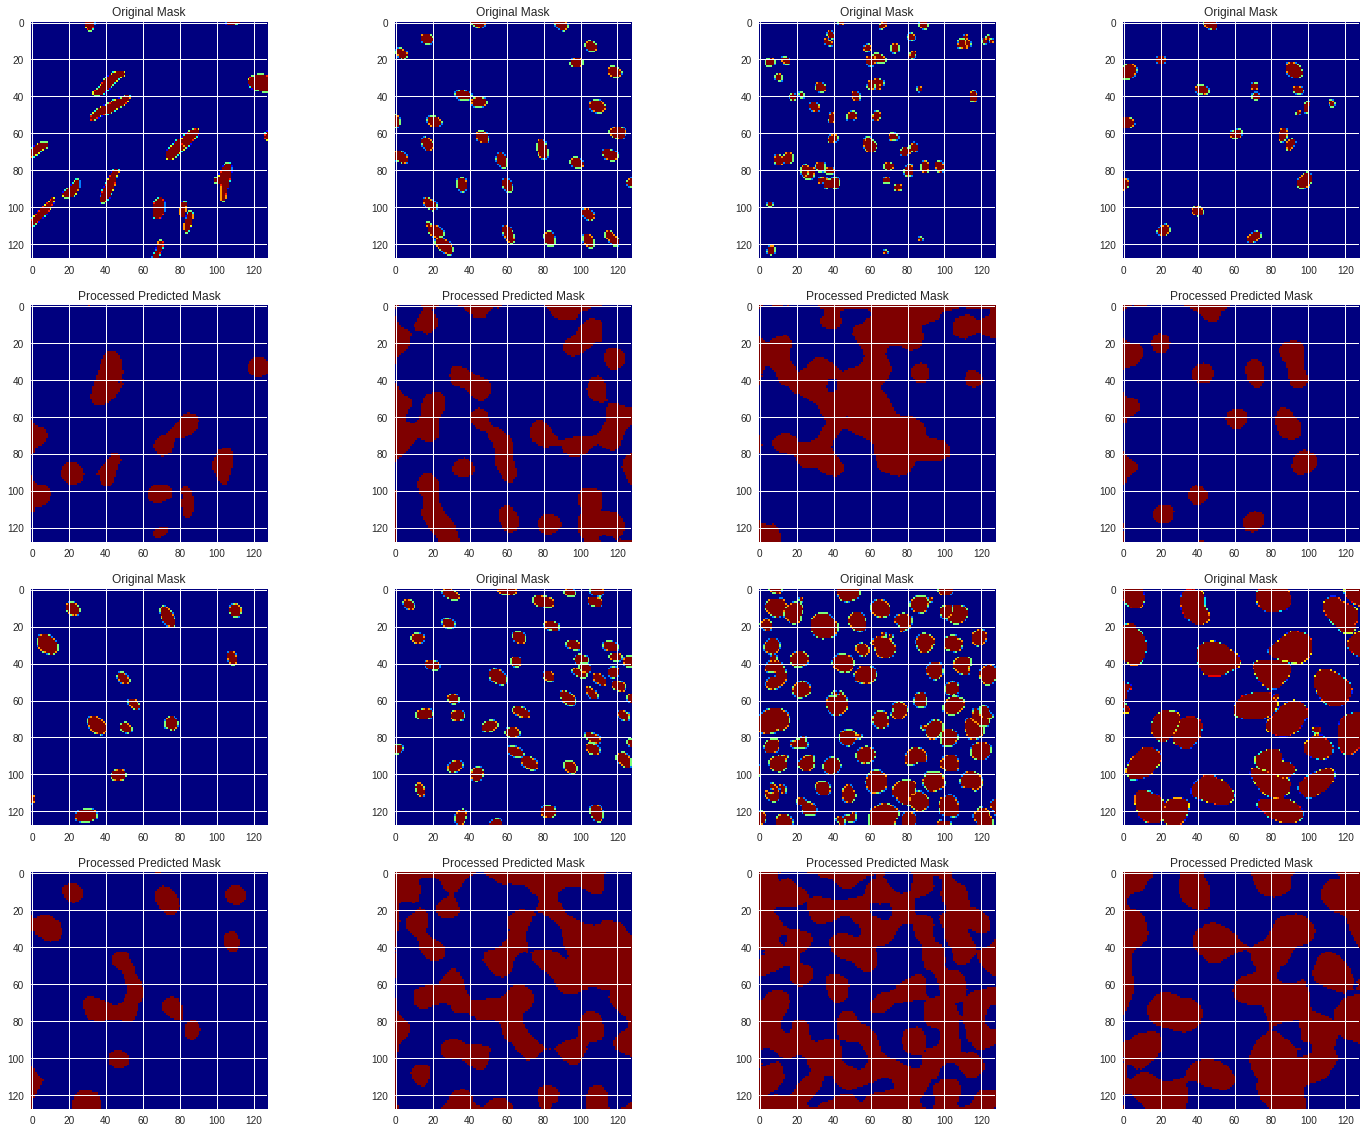

In [66]:
plot_true_predicted_mask(mask_validation, mask_predicted, 0.7, index)

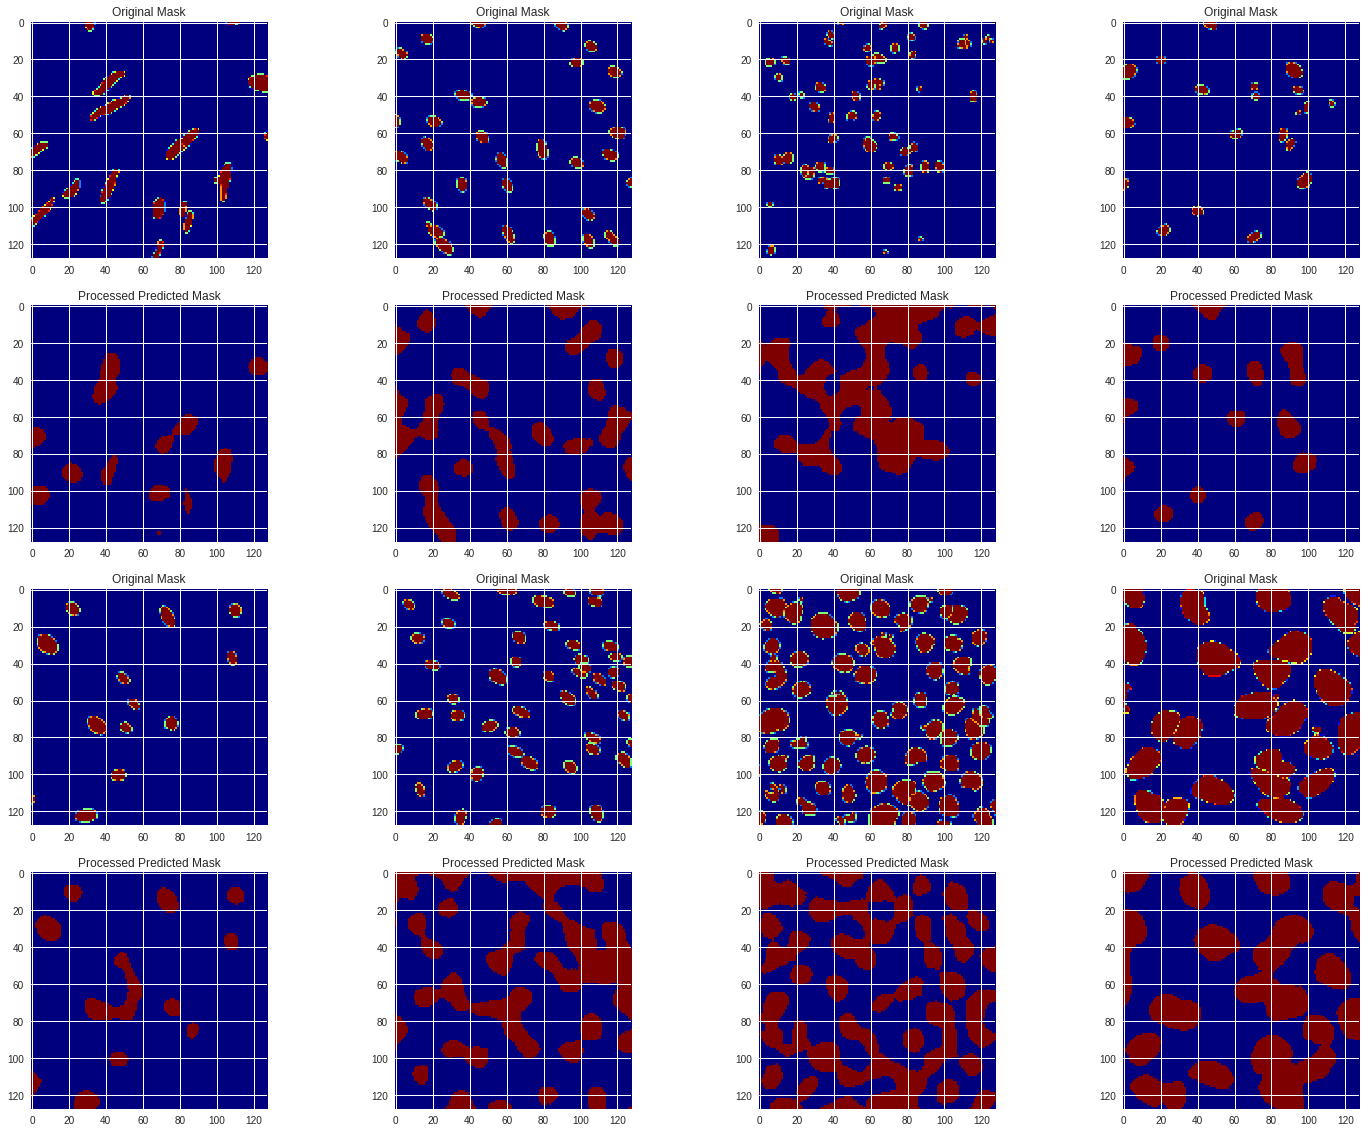

In [67]:
plot_true_predicted_mask(mask_validation, mask_predicted, 0.75, index)

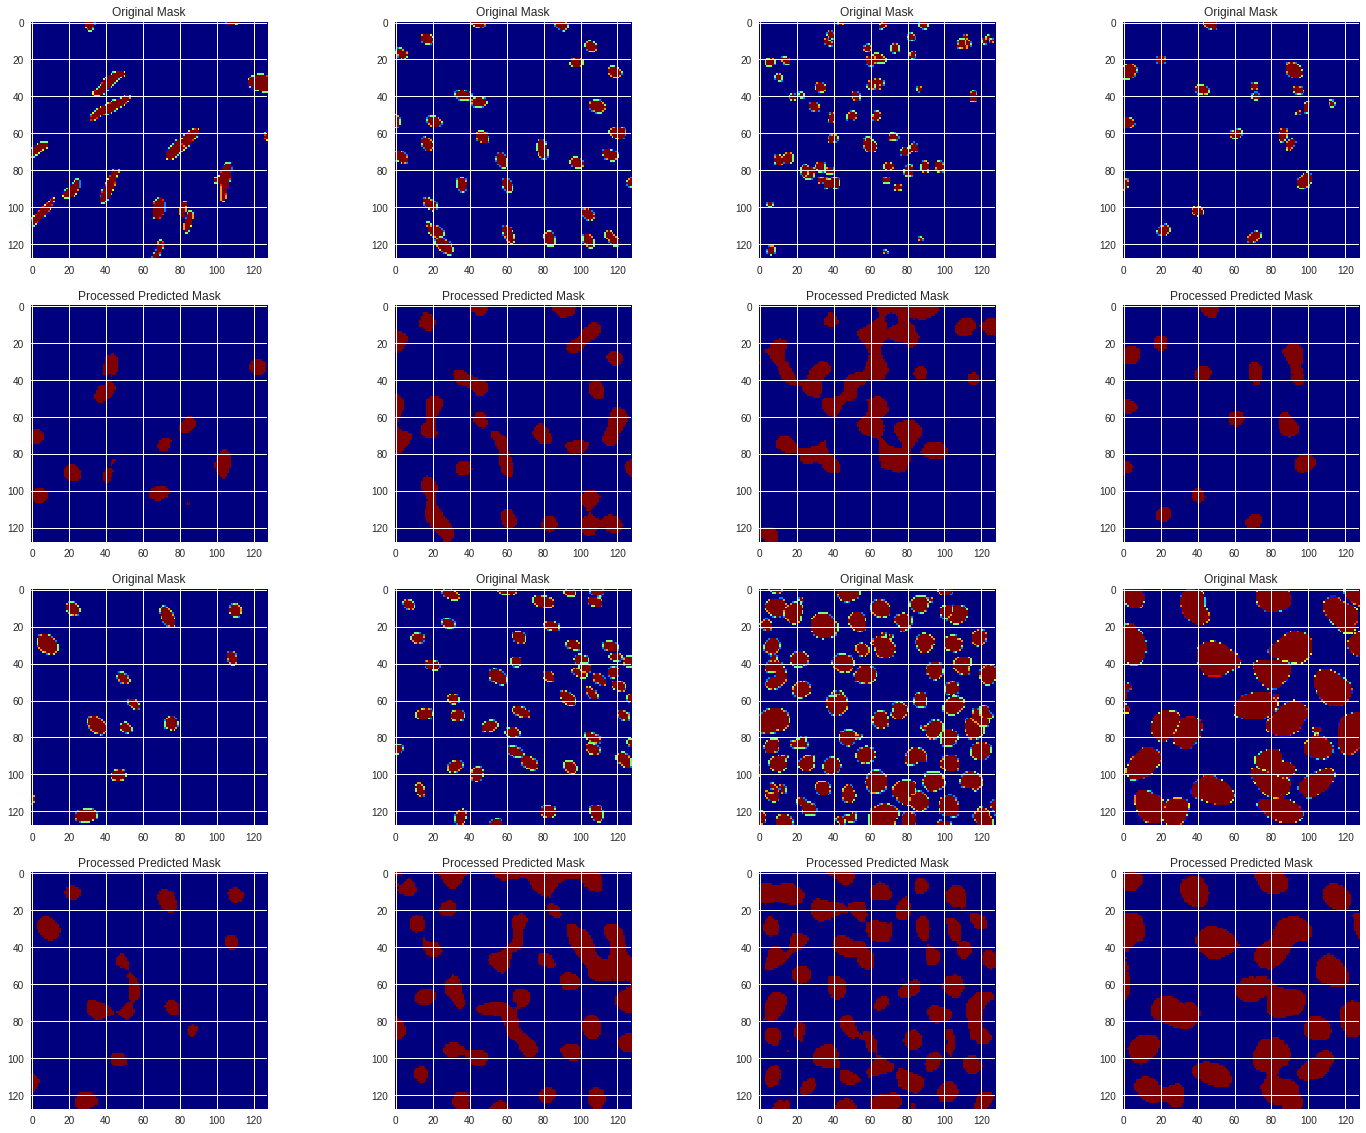

In [68]:
plot_true_predicted_mask(mask_validation, mask_predicted, 0.80, index)

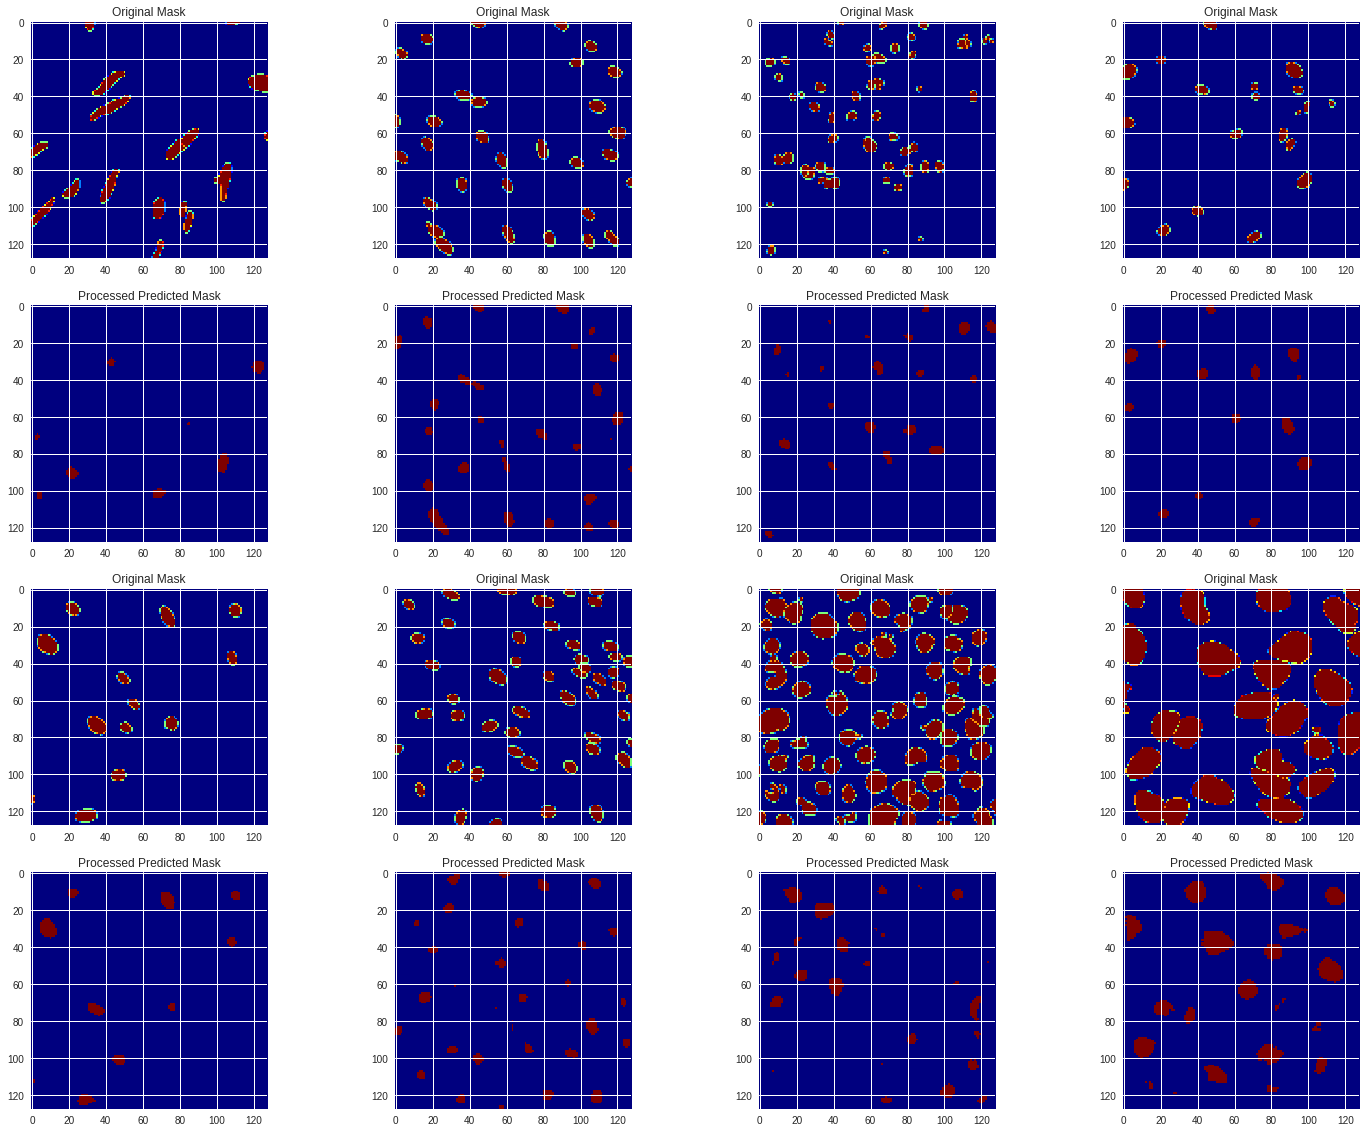

In [69]:
plot_true_predicted_mask(mask_validation, mask_predicted, 0.90, index)

# Compute prediction and save submission file

In [70]:
with tf.Session() as sess:
  
    # restore the best model
    model_path = "./"+"my-model-"+str(best_iteration)
    saver.restore(sess, model_path)
    
    n = len(test_ids)
    k = 10
    step = n//k
    
    # array to store the prediction
    preds = np.array([])
    
    EncodedPixels = []

    # iterate through each fold
    for i in range(k):

        # start and end indices of the fold
        if i != (k-1):
            start = (step*i)
            end = (step*(i+1)) 
        else:
            start = (step*i)
            end = len(test_ids)
        
        # create array of indices
        indices = list(range(start, end))
        indices = np.array(indices)
        
        # generate batch of test data
        image_test, shape_test = generate_batch(indices, test_set = True)
        
        # feed dict
        feed_dict_test =  {x: image_test, batchsize: indices.shape[0]}
        
        # compute predicted masks
        mask_predicted_test = sess.run(out, feed_dict=feed_dict_test)
        
        # encode predicted masks
        EncodedPixels = EncodedPixels + encode_masks(mask_predicted_test, shape_test, threshold = 0.80)
    
    # create a submission file
    submission_path = "./submission.csv"
    submission = pd.DataFrame({"ImageId":test_ids,"EncodedPixels": EncodedPixels}, columns=["ImageId","EncodedPixels" ])
    submission.to_csv(submission_path, header = True, index=False)

INFO:tensorflow:Restoring parameters from ./my-model-689


**Save the submission file in google drive**

In [0]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Create & upload a text file.
uploaded = drive.CreateFile({'title': 'submission.csv', 'parents':[{u'id': file_id_data["folder"]}]})
uploaded.SetContentFile("submission.csv")
uploaded.Upload()